In [3]:
#Importar librerias de Python
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import pickle
import cv2 
#Importar modulos de Util
import util.Reconstruction3d as Res3d
import util.MarkerAruco as MarkerAruco
import util.Depth_Anything_V2_Simple as Depth_Anything_V2_Simple 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


xFormers not available
xFormers not available


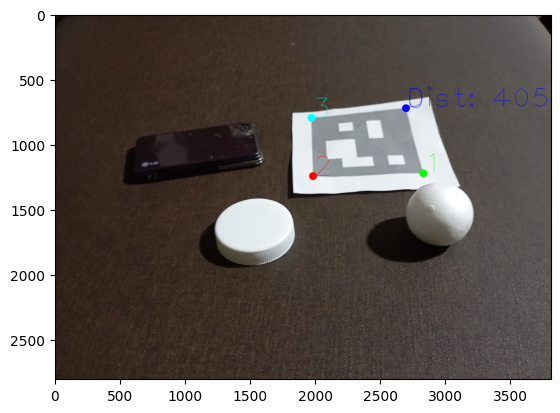

In [4]:
#Lectura de imagen
img = cv2.cvtColor(cv2.imread("./content/Test_Images_Volumen/19.jpg"), cv2.COLOR_BGR2RGB)  #IMG_20250202_12282

#Se cargar la configuracion de la camara
cameraMatrix = pickle.load(open("./calibration/cameraMatrix.pkl", "rb"))
dist = pickle.load(open("./calibration/dist.pkl", "rb"))

#Estimacion de parametros geometricos
parameter_Marker_geometry = MarkerAruco.geometry_estimation(img, 79.2, MarkerAruco.ARUCO_DICT["DICT_5x5_50"], cameraMatrix, dist)
#Eliminacion de distorsion en la imagen
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))
mapx, mapy = cv2.initUndistortRectifyMap(cameraMatrix, dist, None, newcameramtx, (w,h), 5)
img_dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
x, y, w, h = roi
img_dst= img_dst[y:y+h, x:x+w]
#Identificacion de Esquinas
parameter_Marker_corners = MarkerAruco.location_corners(img_dst, MarkerAruco.ARUCO_DICT["DICT_5x5_50"])
#Dibujamos las esquinas y mostramos distancia
img_marker = MarkerAruco.draw_parameter_detection(img_dst, parameter_Marker_geometry, parameter_Marker_corners)
#Vizualisamos resusltados
plt.imshow(img_marker)


In [ ]:
#Guardar imagen
#cv2.imwrite("Img_dis_bola_3.png", img_dst)

True

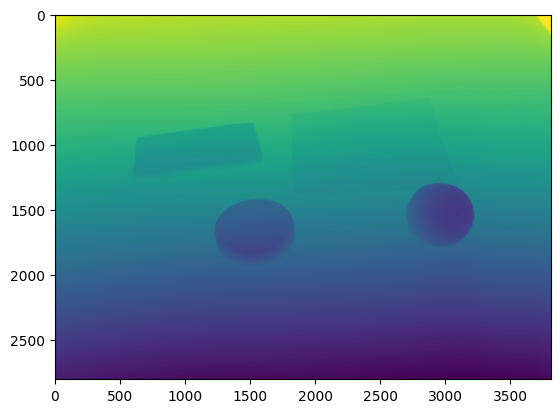

In [5]:
#Instancia del modelo Depth_Anything_V2
depthAythingV2 = Depth_Anything_V2_Simple.ModelDepthAnythingV2('vits',5) 
#Estimamos profundidar de la imagen
img_depth = depthAythingV2.predictionDepth(img_dst)
plt.imshow(img_depth)

In [6]:
# Distancia real conocida en mm
D_real = 111.6  
#Coordenadas u,v,w
u1,u2 = int(parameter_Marker_corners["top_left"][0]) , int(parameter_Marker_corners["bottom_right"][0])
v1,v2 = int(parameter_Marker_corners["top_left"][1]) , int(parameter_Marker_corners["bottom_right"][1])
w1 = img_depth[v1, u1]
w2 = img_depth[v2, u2]
#Calculo factor de escala
scale_factor = (D_real*np.sin(np.pi - parameter_Marker_geometry["theta_XY"]))/abs((w2 - w1))

#Paso de coordenadas relativa a absolutos del mapa de profundidad
image_depth_esc = img_depth*scale_factor #(mm)
image_depth_absolute = image_depth_esc - image_depth_esc[int(parameter_Marker_corners["top_left"][0]), int(parameter_Marker_corners["top_left"][1])] + parameter_Marker_geometry["distance"]
print(image_depth_absolute)


[[864.26332174 864.40363068 864.54393962 ... 892.06430017 891.98465422
  891.90494477]
 [864.26957532 864.39293291 864.51625876 ... 892.06534773 891.98005132
  891.89469142]
 [864.27582891 864.3822034  864.48860964 ... 892.06639528 891.97544843
  891.88443808]
 ...
 [409.41948205 408.95249453 408.48544353 ... 375.13483384 375.20813098
  375.28145986]
 [410.67978647 410.00227205 409.32478939 ... 374.72060503 374.80659981
  374.89259458]
 [411.94005914 411.05208132 410.16413524 ... 374.30634447 374.40503689
  374.50369757]]


In [9]:
#Leer Archivo que contiene la segmentacion
segmentation_file = "./content/Label_Volumen/Img_dis_19_png.txt"   #label_image_undistorsion.txt
with open(segmentation_file, "r") as f:
    lines = f.readlines()
#Contruir mascara deacuerdo al archivo de segmentacion
class_img = 1
width_dst, height_dst = int(np.shape(img_dst)[1]), int(np.shape(img_dst)[0])
mask = Res3d.lines_to_mark_segmentation(lines, class_img, height_dst, width_dst)
#Calculo volumen de la segmentacion
normal = - parameter_Marker_geometry["normal"]
volumen = Res3d.calculation_volumen(image_depth_absolute, mask, normal, cameraMatrix)
print(f"Volumen Alimento: {round(volumen,2)} cm^3")
#Creacion nube de puntos de la segmentacion
pcd = Res3d.depth_to_point_cloud_segmented(image_depth_absolute, mask, normal, cameraMatrix)



Volumen Alimento: 171.93 cm^3


In [7]:
#Visualizacion Nube de puntos segmentada
o3d.visualization.draw_geometries([pcd])


In [88]:
#Creacion nube de puntos de la escena
pcd_completed = Res3d.depth_to_point_cloud_scene(image_depth_absolute, img_dst, cameraMatrix)
o3d.visualization.draw_geometries([pcd_completed])
##################################################################################################################################################

In [ ]:
import numpy as np
from scipy.spatial import Delaunay

#Leer Archivo que contiene la segmentacion
segmentation_file = "./content/Label_Volumen/Img_dis_19_png.txt" #label_image_undistorsion.txt
with open(segmentation_file, "r") as f:
    lines = f.readlines()
#Contruir mascara deacuerdo al archivo de segmentacion
class_img = 1
width_dst, height_dst = int(np.shape(img_dst)[1]), int(np.shape(img_dst)[0])
mask = Res3d.lines_to_mark_segmentation(lines, class_img, height_dst, width_dst)

#Definicion de geometria
width, height = int(np.shape(image_depth_absolute)[1]), int(np.shape(image_depth_absolute)[0])
v, u = np.where(mask)
# Reconstruir coordenadas 3D
Z = image_depth_absolute[v,u]
# Convertir coordenadas de píxeles a coordenadas de cámara
xx = (u - width/2) / cameraMatrix[0,0]
yy = (v - height/2) / cameraMatrix[1,1]
# Multiplicar por la profundidad para obtener puntos en 3D
X = np.multiply(xx, Z)
Y = np.multiply(yy, Z)
# Creacion nube de puntos
points3d_segmented = np.vstack((X, Y, Z)).T
#Busqueda de punto mas alejado en la direccion de la normal inversa
proy= np.dot(points3d_segmented, normal)
indice_max = np.argmax(proy)
point_off = points3d_segmented[indice_max]
#Definicion de variables a partir de parametros
D =  - np.dot(normal, point_off)
# Crear objeto PointCloud de Open3D
points_cloud = o3d.geometry.PointCloud()
points_cloud.points = o3d.utility.Vector3dVector(points3d_segmented)
   


In [18]:
#Visualizacion Nube de puntos segmentada
o3d.visualization.draw_geometries([points_cloud])


In [16]:
import math

pcd = Res3d.depth_to_point_cloud_segmented(image_depth_absolute, mask, normal, cameraMatrix)

[a, b, c] = normal
d = D
pcd_modification = points_cloud.translate((0,0,d/c))
cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
u_1 = b / math.sqrt(a**2 + b**2)
u_2 = -a / math.sqrt(a**2 + b**2)
rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])
pcd_modification.rotate(rotation_matrix)

PointCloud with 256672 points.

In [12]:
#Visualizacion Nube de puntos segmentada
o3d.visualization.draw_geometries([pcd_modification])

In [25]:
downpdc = pcd_modification.voxel_down_sample(voxel_size=0.05)
xyz = np.asarray(downpdc.points)
# Extrae directamente las primeras dos columnas sin usar un bucle
xy_catalog = xyz[:, :2]
# Calcula la triangulación de Delaunay
tri = Delaunay(xy_catalog)

In [19]:
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)

In [24]:
import open3d as o3d
import numpy as np

# Asumiendo que ya tienes las superficies 'surface' y 'tri'
# Obtén los vértices y las caras de la malla
vertices = np.asarray(surface.vertices)
triangles = np.asarray(surface.triangles)

# Encuentra el valor mínimo de z para identificar la base
min_z = np.min(vertices[:, 2])

# Crea nuevos vértices para la base en z = min_z - 1.0 (o ajusta el valor de la base según lo necesites)
base_height = min_z - 1.0  # Ajusta la altura de la base según sea necesario

# Filtra los puntos cercanos a la base
base_points = vertices[vertices[:, 2] == min_z]

# Si no hay puntos cercanos a la base, añade puntos manualmente
# Crea un vértice adicional en la parte inferior
base_vert = np.array([[p[0], p[1], base_height] for p in base_points])

# Si no hay puntos cercanos a la base, podemos generar nuevos puntos cerca de la base
# y cerramos la base con un rectángulo o triángulos
if base_points.shape[0] == 0:
    # Crear puntos adicionales cerca de la base
    base_vert = np.array([
        [np.min(vertices[:, 0]), np.min(vertices[:, 1]), base_height],
        [np.max(vertices[:, 0]), np.min(vertices[:, 1]), base_height],
        [np.max(vertices[:, 0]), np.max(vertices[:, 1]), base_height],
        [np.min(vertices[:, 0]), np.max(vertices[:, 1]), base_height]
    ])

# Nuevos vértices (agregar los de la base)
new_vertices = np.vstack([vertices, base_vert])

# Crear los triángulos para cerrar la base (dependiendo de la forma, puedes usar cuadrados o triángulos)
# Aquí simplemente creamos un cuadrado para cerrar la base (esto depende de la geometría)
base_triangles = np.array([[len(vertices), len(vertices)+1, len(vertices)+2],
                           [len(vertices), len(vertices)+2, len(vertices)+3]])

# Nuevas caras (triángulos para la base)
new_triangles = np.vstack([triangles, base_triangles])

# Actualizar la malla con los nuevos vértices y triángulos
surface.vertices = o3d.utility.Vector3dVector(new_vertices)
surface.triangles = o3d.utility.Vector3iVector(new_triangles)

# Mostrar la malla cerrada
o3d.visualization.draw_geometries([surface])

In [23]:
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(base_vert)
#Visualizacion Nube de puntos segmentada
o3d.visualization.draw_geometries([pc])

In [43]:
import numpy as np
from scipy.spatial import Delaunay
import trimesh

# Obtener los vértices del borde (los que están en el plano XY)
border_vertices = surface.vertices[surface.vertices[:, 2] == 0][:, :2]  # Solo XY
# Triangular la base
tri = Delaunay(border_vertices)
base_faces = tri.simplices
# Crear los triángulos de la base con Z=0
base_triangles = np.c_[border_vertices[base_faces], np.zeros((len(base_faces), 3))]
# Combinar la base con la malla original
new_vertices = np.vstack((surface.vertices, base_triangles.reshape(-1, 3)))
new_faces = np.vstack((surface.triangles, base_faces + len(surface.vertices)))
# Crear la nueva malla cerrada
closed_mesh = trimesh.Trimesh(vertices=new_vertices, faces=new_faces)


TypeError: __getitem__(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.utility.Vector3dVector, s: slice) -> open3d.cpu.pybind.utility.Vector3dVector
    2. (self: open3d.cpu.pybind.utility.Vector3dVector, arg0: int) -> numpy.ndarray[numpy.float64[3, 1]]

Invoked with: std::vector<Eigen::Vector3d> with 602494 elements.
Use numpy.asarray() to access data., (slice(None, None, None), 2)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

In [15]:
import trimesh

mesh = trimesh.Trimesh(vertices=surface.vertices, faces=surface.triangles)
volume = abs(mesh.volume)/1e3
print(f"Volumen con Trimesh: {round(volume, 4)} cm³")


Volumen con Trimesh: 171.9347 cm³


In [ ]:
voxelized = mesh.voxelized(pitch=0.1)  # 10 mm de resolución
volume = voxelized.volume
print(f"Volumen por voxelización: {round((volume/1e3), 4)} cm³")

In [87]:
from scipy.spatial import ConvexHull
import numpy as np

points = np.array(surface.vertices)
hull = ConvexHull(points)
print(f"Volumen del objeto (Convex Hull): {round((hull.volume/1e3), 4)} cm³")

Volumen del objeto (Convex Hull): 120.9315 cm³


In [6]:
#Hallar normales
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [38]:
#Metodo Ball pivoting
nn_distances = pcd.compute_nearest_neighbor_distance()
avg_nn_distance = np.mean(nn_distances)
radius_of_ball = 8 * avg_nn_distance
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius_of_ball, radius_of_ball ]))
o3d.visualization.draw_geometries([bpa_mesh])

: 

In [37]:
#Metodo de Poisson
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, width=0, scale=1.5, linear_fit=False)[0]
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.visualization.draw_geometries([p_mesh_crop]) 

In [7]:
#Metodo de Alpha Snape
alpha_shape_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.1)
bbox = pcd.get_axis_aligned_bounding_box()
a_mesh_crop = alpha_shape_mesh.crop(bbox)
o3d.visualization.draw_geometries([a_mesh_crop])

: 

In [113]:
cd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d_total)

# Estimar las normales
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# Definir radios (puedes ajustar estos valores)
radii = [0.4, 0.7, 0.2]
# Generar la malla con el algoritmo Ball Pivoting
mesh_bpa = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
# Visualizar la malla
o3d.visualization.draw_geometries([mesh_bpa])

In [39]:
# Crear nube de puntos en Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d)
#Computar malla
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=90))
poisson_mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=2, linear_fit=False)
#Eliminar malla sobrante
bbox = pcd.get_axis_aligned_bounding_box()
mesh1 = poisson_mesh.crop(bbox)
# Crear visualizador y agregar nube de puntos
o3d.visualization.draw_geometries([mesh1])

In [30]:
o3d.visualization.draw_geometries([mesh_3d], window_name = "Mesh 3d")

In [ ]:
# -------------------------------Suponiendo que 'combined_verts' es un array (N,3) y 'combined_faces' un array (M,3)---------------------------------
# Convertimos los datos a un objeto TriangleMesh de Open3D.
mesh_o3d = o3d.geometry.TriangleMesh()
mesh_o3d.vertices = o3d.utility.Vector3dVector(combined_verts)
mesh_o3d.triangles = o3d.utility.Vector3iVector(combined_faces)

# Opcional: calcular las normales para una mejor visualización.
mesh_o3d.compute_vertex_normals()

# Visualizamos la malla con Open3D.
o3d.visualization.draw_geometries([mesh_o3d])

In [7]:
# También puedes guardar en STL (compatible con impresión 3D)
o3d.io.write_triangle_mesh("malla_reconstruida.obj", mesh)

NameError: name 'mesh' is not defined